In [1]:
!pip install keras-tuner

     |████████████████████████████████| 61kB 3.3MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.1-cp36-none-any.whl size=73200 sha256=5388e1a66306b90bc5541858b84421df0147ea007778fbb02fa5f3b1aae5da99
  Stored in directory: /root/.cache/pip/wheels/b9/cc/62/52716b70dd90f3db12519233c3a93a5360bc672da1a10ded43
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15356 sha256=52b09e507b3638dfc22d28ad9a8f4220446efbd6c747e3494aac117d253e1d11
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [25]:
import numpy as np 
import pandas as pd 
import os
import cv2
import matplotlib.pyplot as plt
import random
from functools import partial
import keras
from keras.models import Sequential,load_model
from keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import kerastuner as kt
from kerastuner.engine.hyperparameters import HyperParameters
from keras.callbacks import ReduceLROnPlateau
import shutil
from keras.regularizers import l2
from sklearn.metrics import classification_report,confusion_matrix

In [4]:
SHAPE_OF_IMAGES = (150,150)

In [5]:
def get_data_from_dir(curr_path,labels): 
    data = []
    data_labels = []
    for label in labels: 
        path = os.path.join(curr_path, label)
        num_label = labels.index(label) 
        for image in os.listdir(path):
            p_dir = os.path.join(path, image)
            try:
              img = cv2.resize(cv2.imread(p_dir),SHAPE_OF_IMAGES)
              data.append(img)
              data_labels.append(num_label)
            except:
              print(p_dir)
    return np.array(data), np.array(data_labels)

In [6]:
train_dir = '/content/drive/My Drive/chest_xray/chest_xray/train'
test_dir = '/content/drive/My Drive/chest_xray/chest_xray/test'
val_dir = '/content/drive/My Drive/chest_xray/chest_xray/val'

In [7]:
x_train,y_train = get_data_from_dir(train_dir,["NORMAL","PNEUMONIA"])
x_test,y_test = get_data_from_dir(test_dir,["NORMAL","PNEUMONIA"])
x_val,y_val = get_data_from_dir(val_dir,["NORMAL","PNEUMONIA"])

/content/drive/My Drive/chest_xray/chest_xray/train/NORMAL/.DS_Store
/content/drive/My Drive/chest_xray/chest_xray/train/PNEUMONIA/.DS_Store
/content/drive/My Drive/chest_xray/chest_xray/val/NORMAL/.DS_Store
/content/drive/My Drive/chest_xray/chest_xray/val/PNEUMONIA/.DS_Store


Text(0.5, 1.0, 'Validation data set')

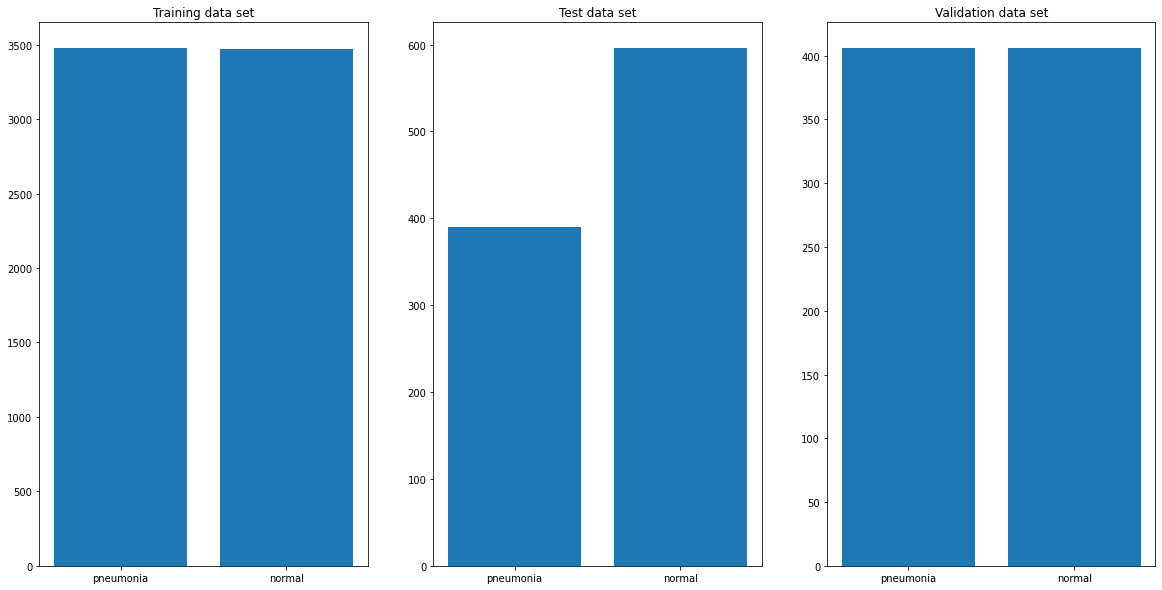

In [8]:
f = plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.bar(x=["pneumonia","normal"], height = (np.where(y_train == 1)[0].shape[0],np.where(y_train == 0)[0].shape[0]))
plt.title("Training data set")
plt.subplot(1,3,2)
plt.bar(x=["pneumonia","normal"], height = (np.where(y_test == 1)[0].shape[0],np.where(y_test == 0)[0].shape[0]))
plt.title("Test data set")
plt.subplot(1,3,3)
plt.bar(x=["pneumonia","normal"], height = (np.where(y_val == 1)[0].shape[0],np.where(y_val == 0)[0].shape[0]))
plt.title("Validation data set")

In [9]:
def view_images(x,y,n_of_images):
    plt.figure(figsize = (20,5))
    for i in range(n_of_images):
        random_label = random.choice(range(len(y)))
        plt.subplot(2,int(n_of_images/2),i+1)
        plt.imshow(x[random_label])
        plt.axis("off")
        plt.title(["Normal","Pneumonia"][y[random_label]])
    plt.tight_layout()
    plt.show()

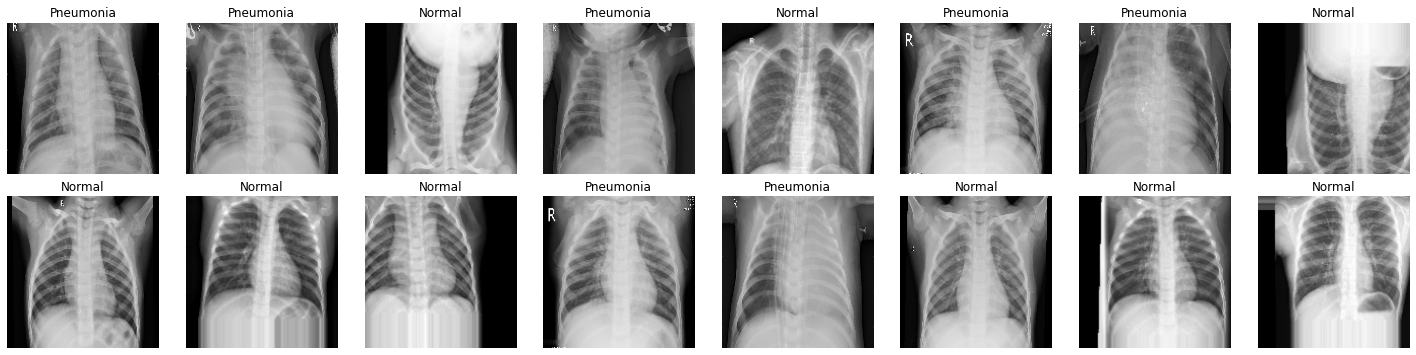

In [10]:
view_images(x_test,y_test,16)

In [11]:
x_train = x_train / 255

x_test = x_test / 255

x_val = x_val / 255


In [ ]:
#train_data_generator = ImageDataGenerator(
 #  width_shift_range=0.2,
  #  height_shift_range=0.2,
   # zoom_range=0.1,
   # horizontal_flip = False,
   # vertical_flip = True
#)
#train_gen = train_data_generator.flow(x_test[:234],save_to_dir='/content/drive/My Drive/chest_xray/chest_xray/test/NORMAL')
#count = 0
#for batch in train_gen:
#  count +=1
#  if count == 12:
#    break

In [12]:
model = Sequential([
        Conv2D(filters=64,kernel_size=3,activation = 'relu',padding = 'same', kernel_regularizer=l2(0.005), bias_regularizer=l2(0.005),input_shape = (150,150,3)),
        Dropout(0.25),
        BatchNormalization(),
        MaxPooling2D(padding= 'same'),
        Conv2D(filters=128,kernel_size=3,activation = 'relu',padding = 'same', kernel_regularizer=l2(0.005), bias_regularizer=l2(0.005)),
        Dropout(0.25),
        BatchNormalization(),
        MaxPooling2D(padding= 'same'),
        Flatten(),
        Dense(units = 256,activation= 'relu', kernel_regularizer=l2(0.1), bias_regularizer=l2(0.1)),
        Dropout(0.25),
        BatchNormalization(),
        Dense(units = 128,activation= 'relu', kernel_regularizer=l2(0.1), bias_regularizer=l2(0.1)),
        Dropout(0.25),
        BatchNormalization(),
        Dense(1,activation='sigmoid')
])
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),loss = 'binary_crossentropy',metrics=['accuracy'])


In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 64)      1792      
_________________________________________________________________
dropout (Dropout)            (None, 150, 150, 64)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 128)       73856     
_________________________________________________________________
dropout_1 (Dropout)          (None, 75, 75, 128)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 128)       5

In [ ]:
history = model.fit(x=x_train,y=y_train,batch_size=len(x_train) // 50 ,epochs = 50, verbose = 1,validation_data=(x_val,y_val),validation_batch_size=len(x_val)//50)

In [ ]:
model.evaluate(x_test,y_test)

31/31 [==============================] - 0s 12ms/step - loss: 0.9581 - accuracy: 0.8479


[0.9580703973770142, 0.8478701710700989]

In [ ]:
model.save('/content/drive/My Drive/chest_xray')

INFO:tensorflow:Assets written to: /content/drive/My Drive/chest_xray/assets


In [27]:
model = load_model('/content/drive/My Drive/chest_xray/saved_model.pb')

OSError: ignored

In [ ]:
plt.figure(figsize=(25,10))
plt.plot(range(1,51),history.history['accuracy'],color="blue", label="Training accuracy", linestyle="-")
plt.plot(range(1,51),history.history['val_accuracy'],color="red", label="Validation accuracy", linestyle="-")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training accuracy VS Validation accuracy")
plt.legend()
plt.show()

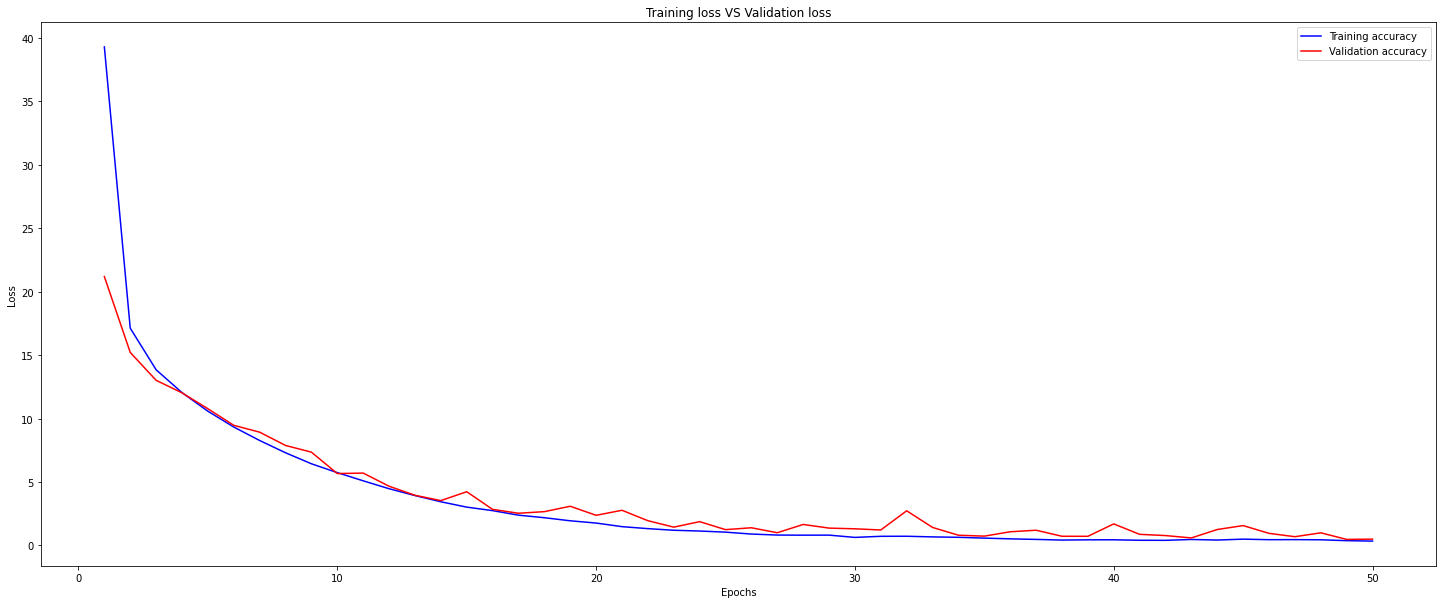

In [ ]:
plt.figure(figsize=(25,10))
plt.plot(range(1,51),history.history['loss'],color="blue", label="Training loss", linestyle="-")
plt.plot(range(1,51),history.history['val_loss'],color="red", label="Validation loss", linestyle="-")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Training loss VS Validation loss")
plt.legend()
plt.show()

In [ ]:
y_pred = model_lol.predict_classes(x_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.97      0.77      0.86       596
           1       0.73      0.96      0.83       390

    accuracy                           0.85       986
   macro avg       0.85      0.87      0.85       986
weighted avg       0.88      0.85      0.85       986



In [ ]:
cm = confusion_matrix(y_test,y_pred)
cm

array([[460, 136],
       [ 14, 376]])

In [ ]:
import seaborn as sns
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cm.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt='')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


NameError: ignored

In [ ]:
#def move_images(start_dir,end_dir,n_of_images):
 # for image in os.listdir(start_dir):
  #  n_of_images -= 1
   # if n_of_images > 0:
    #  shutil.move(os.path.join(start_dir,image),end_dir)


In [ ]:
#move_images(start_dir= train_dir + '/NORMAL',end_dir= val_dir + '/NORMAL',n_of_images=200)